Для временного ряда bike-sharing построить три модели:
* Датасет аггрегировать по неделям
* Простое экспоненциальное сглаживание
* Двойное экспоненциальное сглаживание
* Тройное экспоненциальное сглаживание (тип модели additive или multiplicative) выбрать самостоятельно 


Для финального отчета сделать кросс-валидацию, пояснить выбранные метрики, а так же их финальные значения.

In [152]:
import pandas as pd
df = pd.read_csv('../datatest/bike-sharing.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,9.84,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,9.02,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,9.02,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,9.84,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,9.84,0.2879,0.75,0.0,0,1,1


# Решение

## Агрегация

In [153]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.model_selection import TimeSeriesSplit

import warnings;
warnings.filterwarnings('ignore');

In [154]:
df = pd.read_csv('../datatest/bike-sharing.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,9.84,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,9.02,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,9.02,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,9.84,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,9.84,0.2879,0.75,0.0,0,1,1


In [155]:
df = df[['dteday','cnt']]

In [156]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [157]:
df.set_index('dteday',inplace=True)

In [158]:
df=df.resample('W').sum()

<AxesSubplot:xlabel='dteday'>

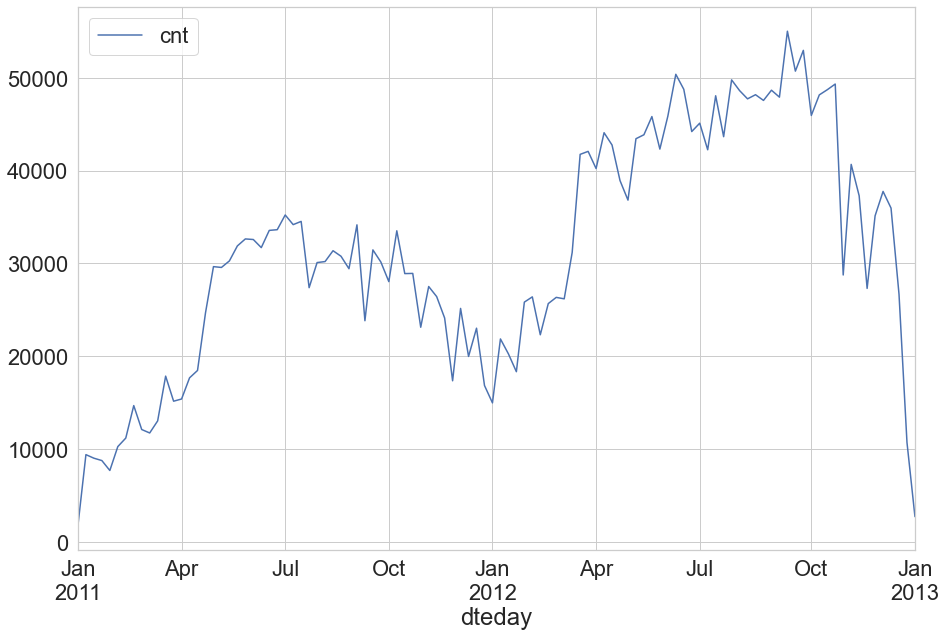

In [159]:
df.plot()

In [160]:
s = df['cnt']

In [161]:
decompose_result = seasonal_decompose(s,model='additive')

In [162]:
trend, seasonal, resid = decompose_result.trend, decompose_result.seasonal, decompose_result.resid

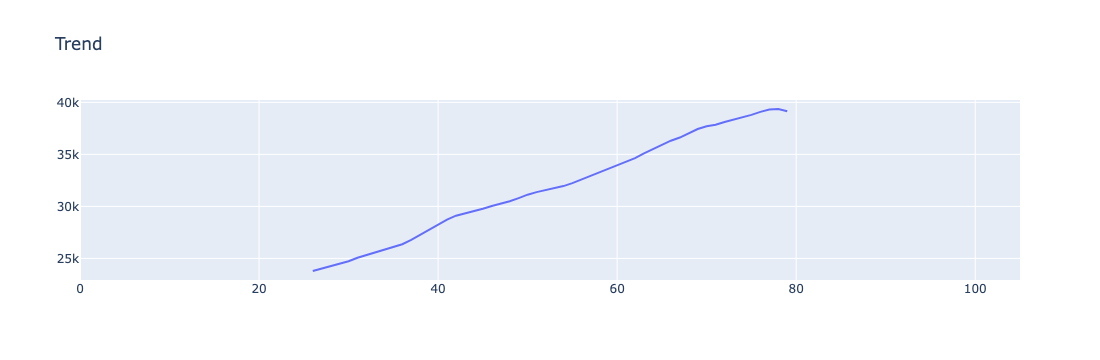

In [163]:
iplot(Figure(data=Scatter(y=trend),
            layout=Layout(title='Trend')))

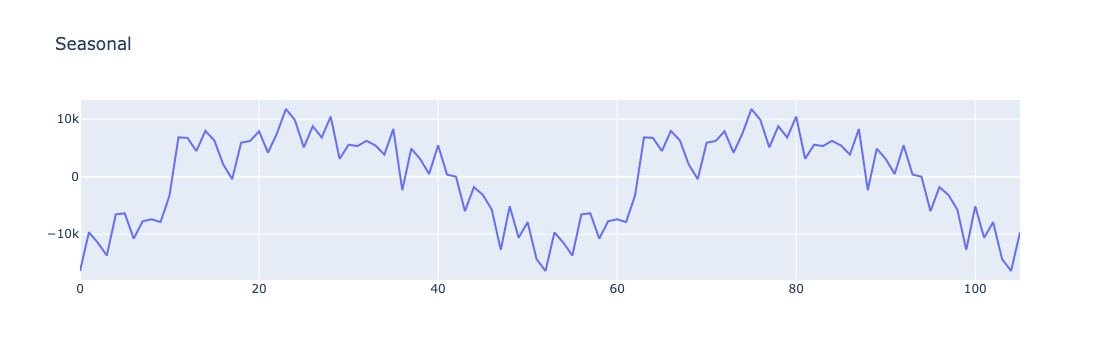

In [164]:
iplot(Figure(data=Scatter(y=seasonal),
            layout=Layout(title='Seasonal')))

Видим годовую сезонность. 

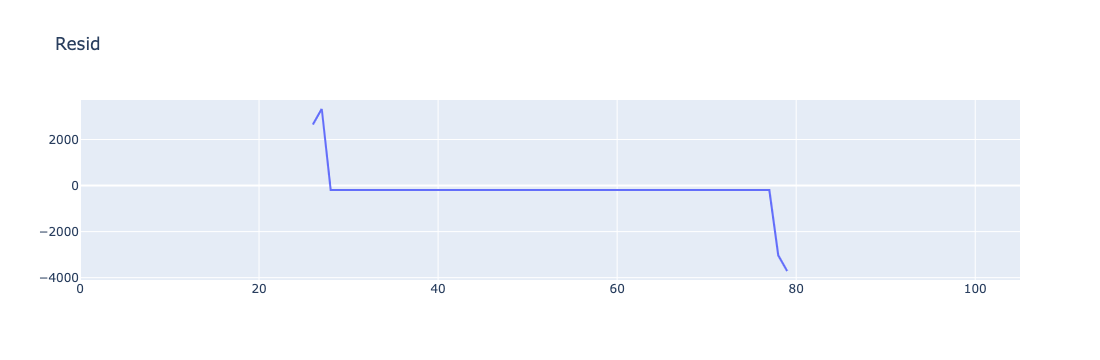

In [165]:
iplot(Figure(data=Scatter(y=resid),
            layout=Layout(title='Resid')))

## Простое экспоненциальное сглаживание

In [166]:
df['ses'] = SimpleExpSmoothing(s).fit(smoothing_level=1/(1*12), optimized=False, use_brute=True).fittedvalues

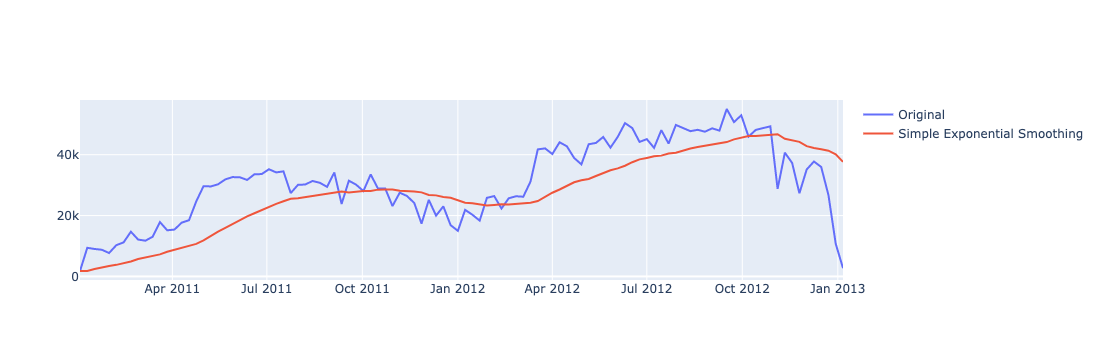

In [167]:
iplot(Figure(data=[Scatter(x = df.index,
                           y = df['cnt'],
                          name = 'Original'),
                  Scatter(x = df.index,
                         y = df['ses'],
                         name = 'Simple Exponential Smoothing')]))

### Кросс-валидация

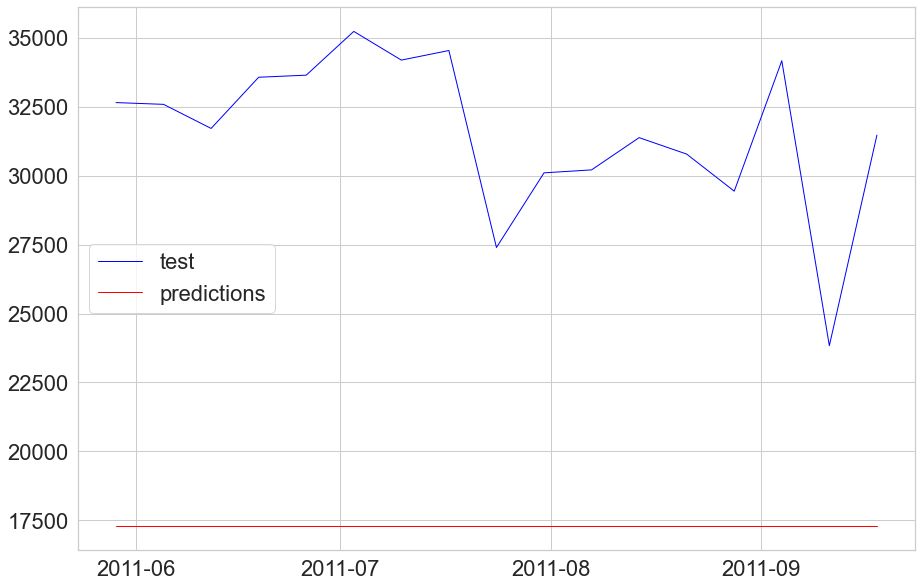

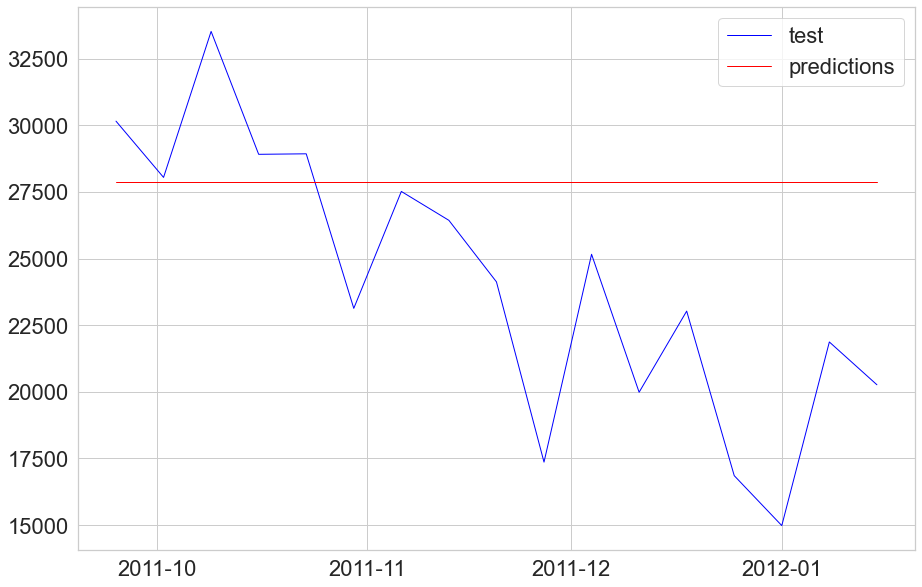

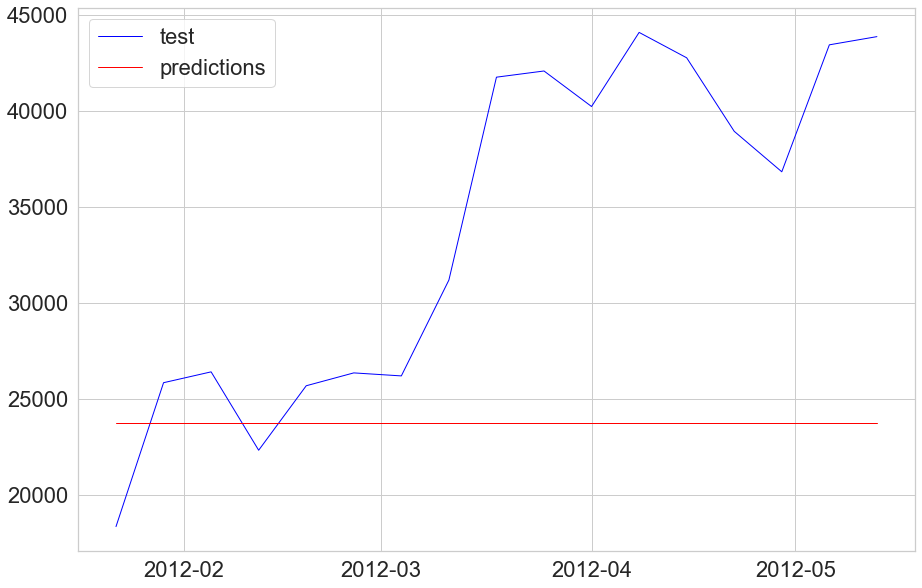

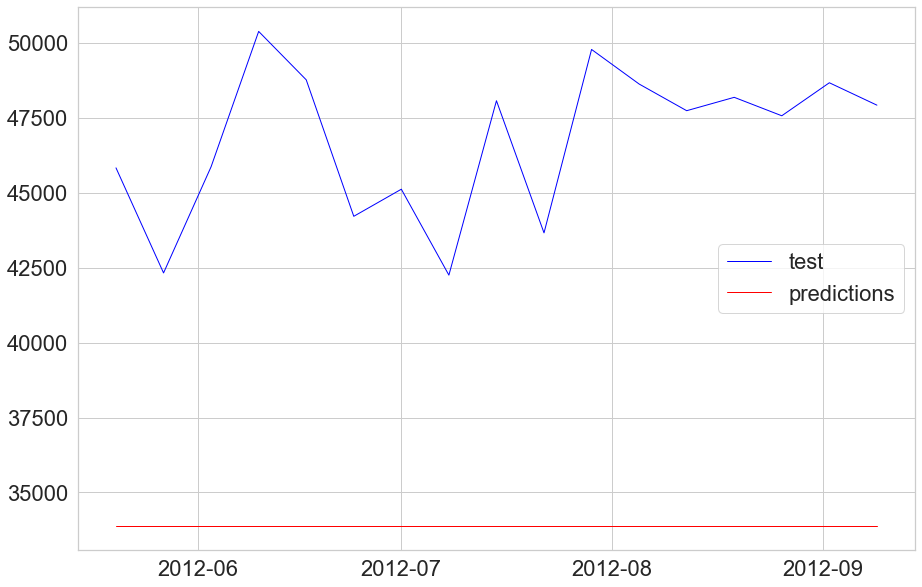

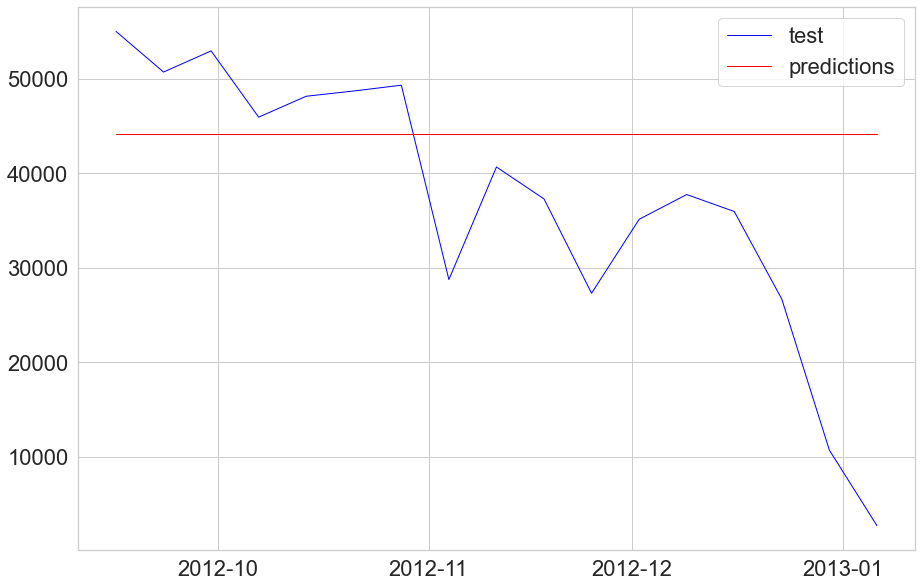

mae: 10965.088726202854 r2: -11.250434104071003


In [183]:
mae_list = list()
r2_list = list()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(s):
    train, test = s[train_index], s[test_index]

    mod = SimpleExpSmoothing(train).fit(smoothing_level=1/(1*12), optimized=False, use_brute=True)
    predictions = mod.forecast(len(test))
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))
    # iplot(Figure(data=[Scatter(y = test,
    #                       name = 'test'),
    #               Scatter(y = predictions,
    #                      name = 'predictions')]))
    
    fig, ax = plt.subplots()
    ax.plot(test, linewidth = 1, color='blue',label = 'test')
    ax.plot(predictions, linewidth = 1, color = 'red', label = 'predictions')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.legend()
    plt.show()
        
print('mae:', np.mean(mae_list), 'r2:', np.mean(r2_list))

## Двойное экспоненциальное сглаживание

In [169]:
df['des_add'] = ExponentialSmoothing(s, trend='add').fit().fittedvalues

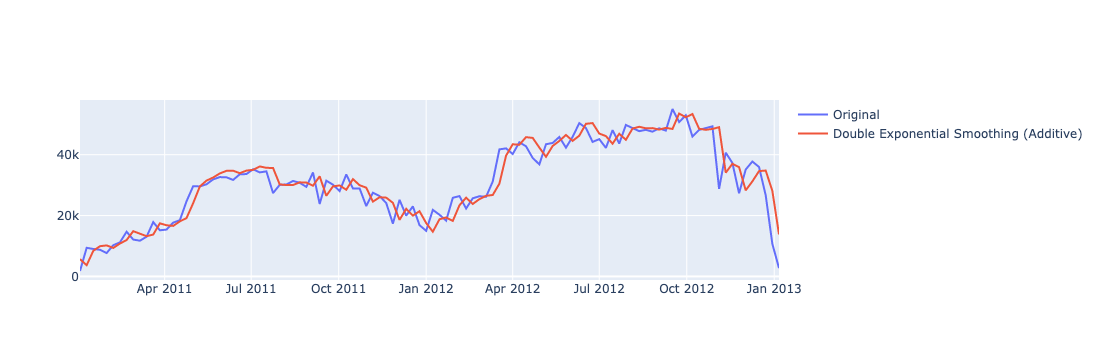

In [170]:
iplot(Figure(data=[Scatter(x = df.index,
                           y = df['cnt'],
                          name = 'Original'),
                  Scatter(x = df.index,
                          y = df['des_add'],
                         name = 'Double Exponential Smoothing (Additive)')
                  ]))

### Кросс-валидация

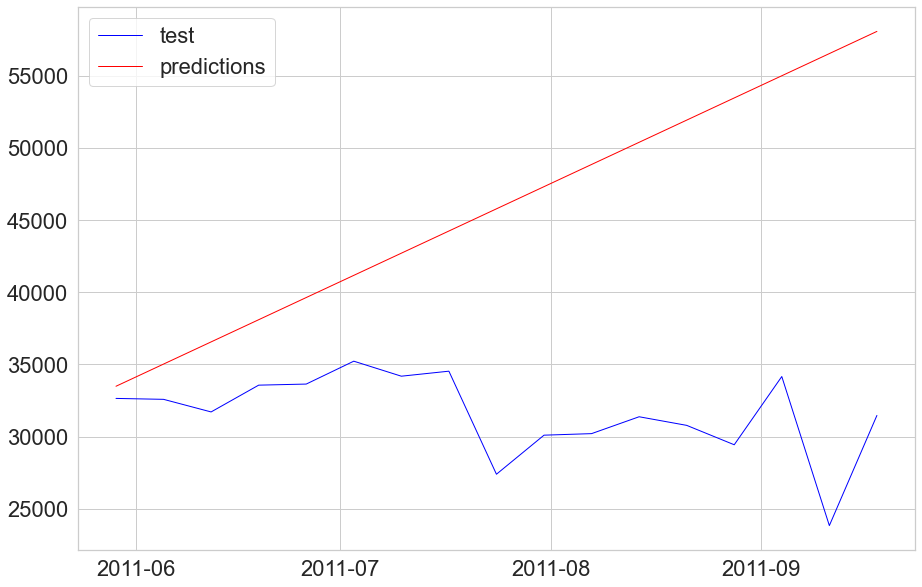

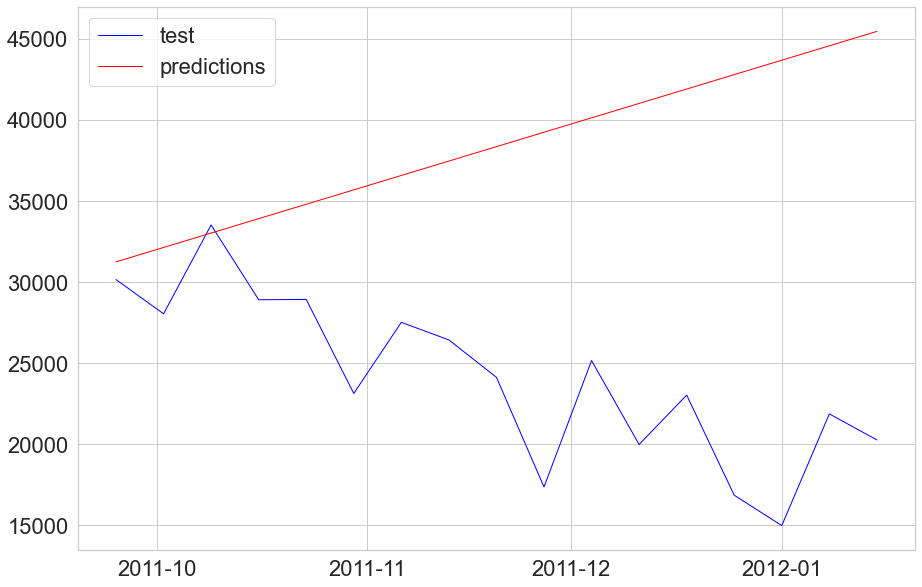

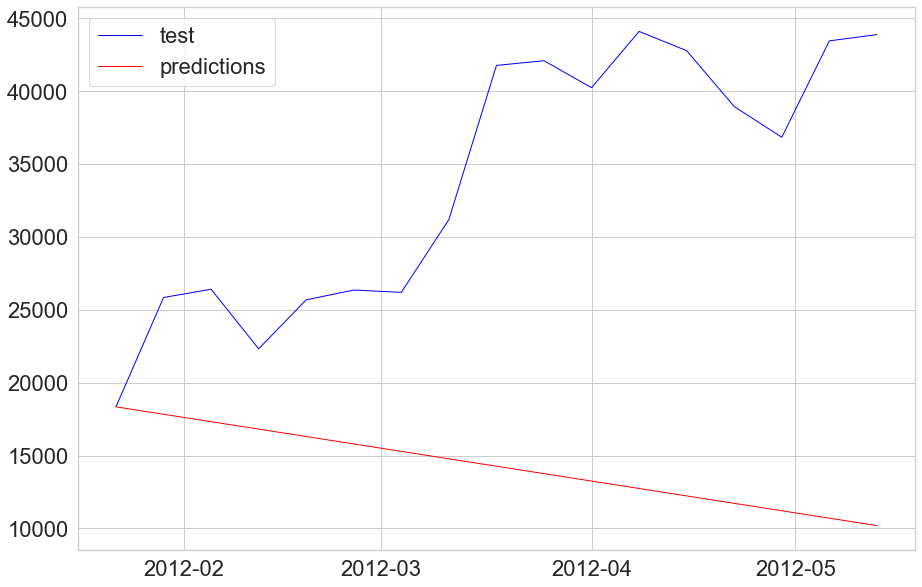

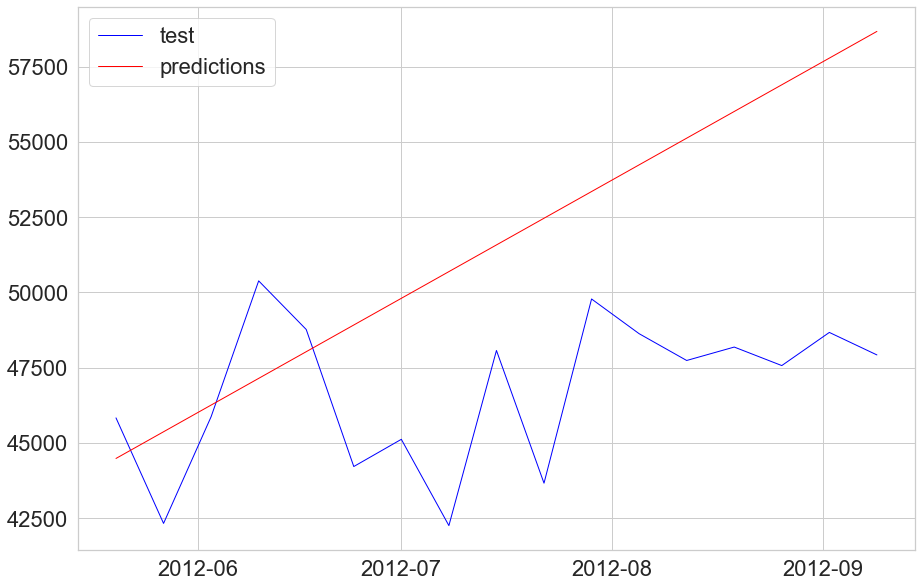

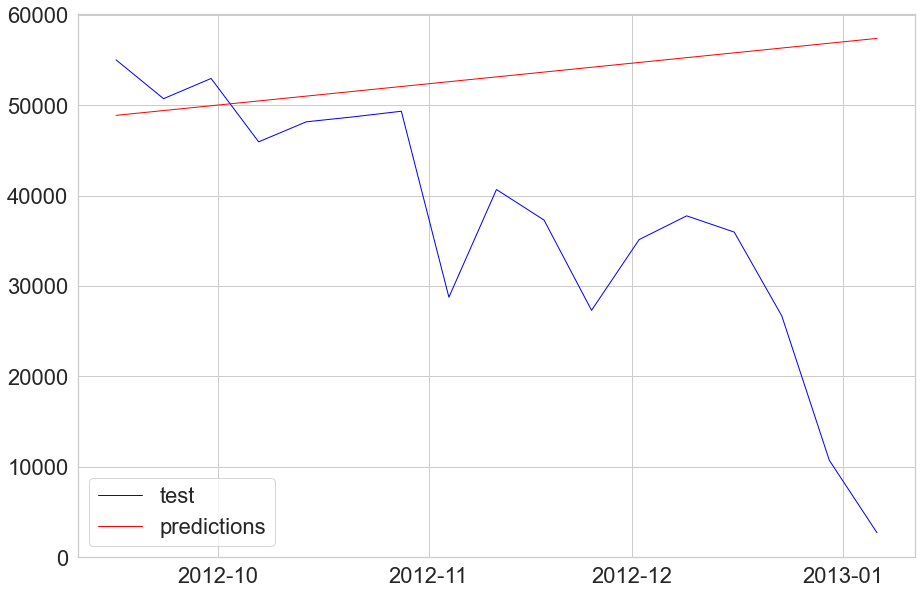

mae: 14125.389201130733 r2: -11.80539274697181


In [184]:
mae_list = list()
r2_list = list()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(s):
    train, test = s[train_index], s[test_index]

    mod = ExponentialSmoothing(train, trend='add').fit()
    predictions = mod.forecast(len(test))
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))
    
    # iplot(Figure(data=[Scatter(y = test,
    #                       name = 'test'),
    #               Scatter(y = predictions,
    #                      name = 'predictions')]))
    
    fig, ax = plt.subplots()
    ax.plot(test, linewidth = 1, color='blue',label = 'test')
    ax.plot(predictions, linewidth = 1, color = 'red', label = 'predictions')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.legend()
    plt.show()
        
print('mae:', np.mean(mae_list), 'r2:', np.mean(r2_list))

## Тройное экспоненциальное сглаживание

In [174]:
df['tes_add'] = ExponentialSmoothing(s, trend='add', seasonal='add', seasonal_periods=52).fit().fittedvalues

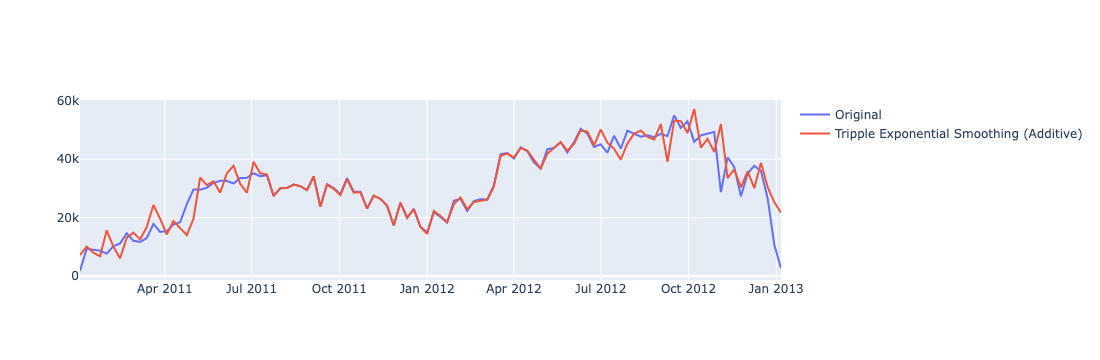

In [175]:
iplot(Figure(data=[Scatter(x =df.index,
                          y = df['cnt'],
                          name = 'Original'),
                  Scatter(x = df.index,
                         y = df['tes_add'],
                         name = 'Tripple Exponential Smoothing (Additive)')
                  ]))

Поскольку у нас в сезоне 52 наблюдения, выберем seasonal_periods=52

### Кросс-валидация

In [ ]:
mae_list = list()
r2_list = list()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(s):
    train, test = s[train_index], s[test_index]

    mod = ExponentialSmoothing(train, trend='add', seasonal='add').fit()
    predictions = mod.forecast(len(test))
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))
    
    # iplot(Figure(data=[Scatter(y = test,
    #                       name = 'test'),
    #               Scatter(y = predictions,
    #                      name = 'predictions')]))
    
    fig, ax = plt.subplots()
    ax.plot(test, linewidth = 1, color='blue',label = 'test')
    ax.plot(predictions, linewidth = 1, color = 'red', label = 'predictions')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.legend()
    plt.show()
        
print('mae:', np.mean(mae_list), 'r2:', np.mean(r2_list))

## Метрики

In [176]:
print('mae:', mean_absolute_error(df['cnt'], df['ses']))
print('r2:', r2_score(df['cnt'], df['ses']))

mae: 7755.85171853074
r2: 0.42736804007196083


In [177]:
print('mae:', mean_absolute_error(df['cnt'], df['des_add']))
print('r2:', r2_score(df['cnt'], df['des_add']))

mae: 3316.8555948479516
r2: 0.8615582513472932


In [178]:
print('mae:', mean_absolute_error(df['cnt'], df['tes_add']))
print('r2:', r2_score(df['cnt'], df['tes_add']))

mae: 2489.348546968067
r2: 0.8704892579206602


## Выводы по кросс-валидации

- Простое экспоненциальное сглаживание (mae: 10965.088726202854 r2: -11.250434104071003), не учитывает сезонность и тренд.
- Двойное экспоненциальное сглаживание (mae: 14125.389201130733 r2: -11.80539274697181), уже учитывает тренд, но метрики тоже плохие
- Кросс-валидации для тройного экспоненциального сглаживания не сработала, т.к. в train меньше двух сезонов

## Выводы по метрикам

Выбраны метрики MAE и R2. MAE относительно легко интерпретируется как средняя абсолютная ошибка. R2 показывает общее качество для разных моделей.
С усложнением модели в данном случае метрики улучшаются: ошибка MAE уменьшается, R2 растет к единице.